In [12]:
import numpy as np
import pandas as pd
import yaml
import json
from pathlib import Path
from litdata import StreamingDataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

# Set up paths
ROOT_DIR = Path.cwd().parent
CONFIG_DIR = ROOT_DIR / "configs"
DATA_DIR = ROOT_DIR / "data" / "optimized"

# Load configuration
with open(CONFIG_DIR / "optimise_config.yml", "r") as f:
    config = yaml.safe_load(f)

with open(CONFIG_DIR / "paths.yml", "r") as f:
    paths = yaml.safe_load(f)

# Load normalization stats
with open(DATA_DIR / "normalization_stats.json", "r") as f:
    norm_stats = json.load(f)

# Get feature names from config
input_features = config["data"]["input_features"]
micro_features = config["data"]["output_features"]["microstructure"]
perf_features = config["data"]["output_features"]["performance"]

print("=" * 80)
print("🔋 Optimized Battery Dataset Validation")
print("=" * 80)
print(f"\n✓ Configuration loaded")
print(f"   Input features: {len(input_features)}")
print(f"   Microstructure outputs: {len(micro_features)}")
print(f"   Performance outputs: {len(perf_features)}")

# Load the datasets
train_dir = DATA_DIR / "train"
val_dir = DATA_DIR / "val"
test_dir = DATA_DIR / "test"

train_dataset = StreamingDataset(input_dir=str(train_dir))
val_dataset = StreamingDataset(input_dir=str(val_dir))
test_dataset = StreamingDataset(input_dir=str(test_dir))

print(f"\n📊 Dataset Statistics:")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")
print(f"   Test samples: {len(test_dataset)}")
print(f"   Total: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

# Load a sample
sample_idx = 0  # Change this to view different samples
sample = train_dataset[sample_idx]

print(f"\n✓ Loaded sample {sample_idx} from training set")
print(f"\n📦 Sample Structure:")
print(f"   Keys: {list(sample.keys())}")
print(f"   Image shape: {sample['image'].shape}")
print(f"   Image dtype: {sample['image'].dtype}")
print(f"   Input params shape: {sample['input_params'].shape}")
print(f"   Microstructure outputs shape: {sample['microstructure_outputs'].shape}")
print(f"   Performance outputs shape: {sample['performance_outputs'].shape}")
print(f"   Sample ID: {sample['sample_id']}")
print(f"   Param ID: {sample['param_id']}")

print("\n" + "=" * 80)

🔋 Optimized Battery Dataset Validation

✓ Configuration loaded
   Input features: 10
   Microstructure outputs: 4
   Performance outputs: 6

📊 Dataset Statistics:
   Training samples: 3565
   Validation samples: 450
   Test samples: 481
   Total: 4496

✓ Loaded sample 0 from training set

📦 Sample Structure:
   Keys: ['image', 'input_params', 'microstructure_outputs', 'performance_outputs', 'sample_id', 'param_id']
   Image shape: (128, 128, 128)
   Image dtype: float32
   Input params shape: (10,)
   Microstructure outputs shape: (4,)
   Performance outputs shape: (6,)
   Sample ID: 0
   Param ID: 0



🔬 Visualizing Microstructure - Sample 0, Param 0
   Shape: (128, 128, 128)
   Value range: [0.000, 1.000]
   Porosity (fraction of 0s): 48.06%
   Solid (fraction of 1s): 51.94%


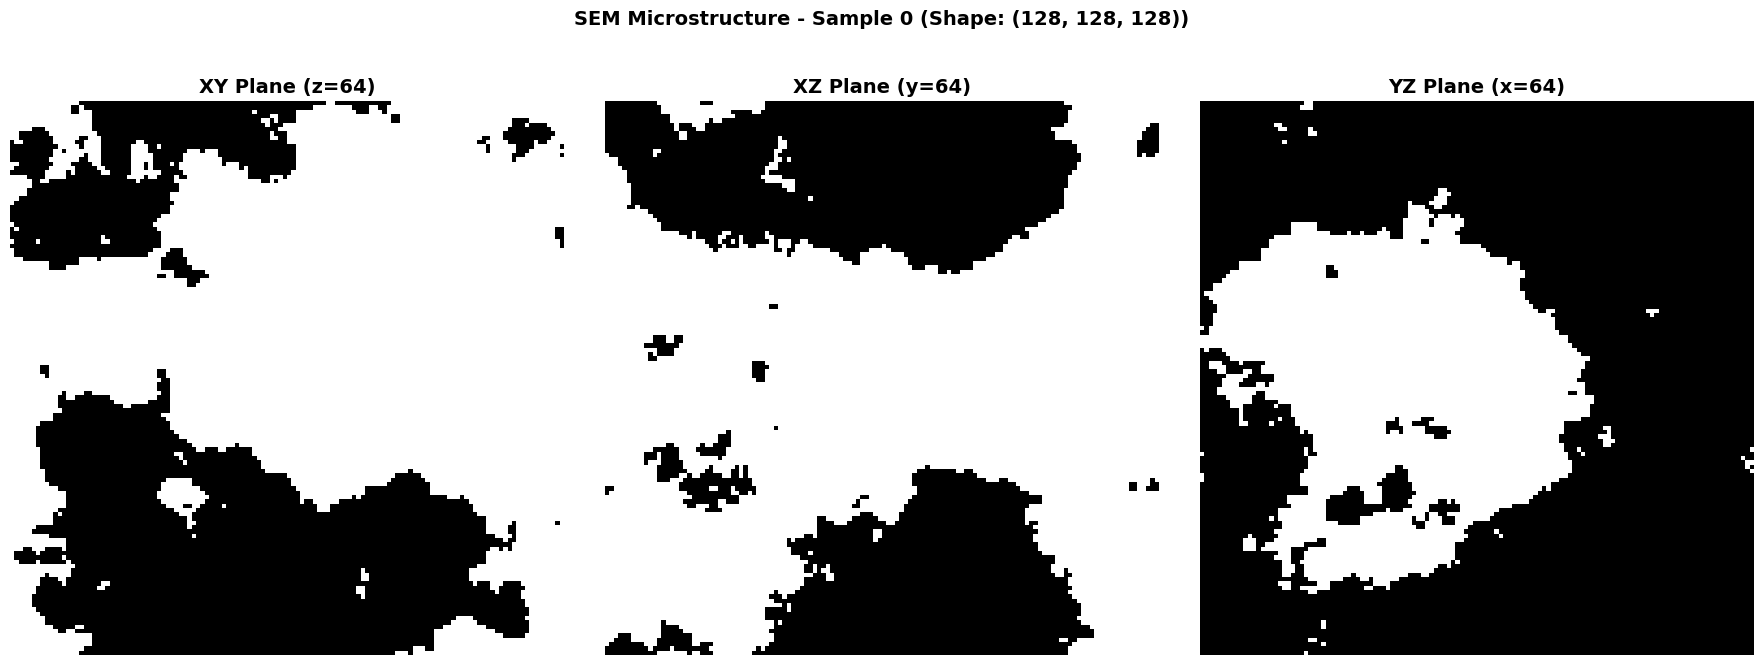

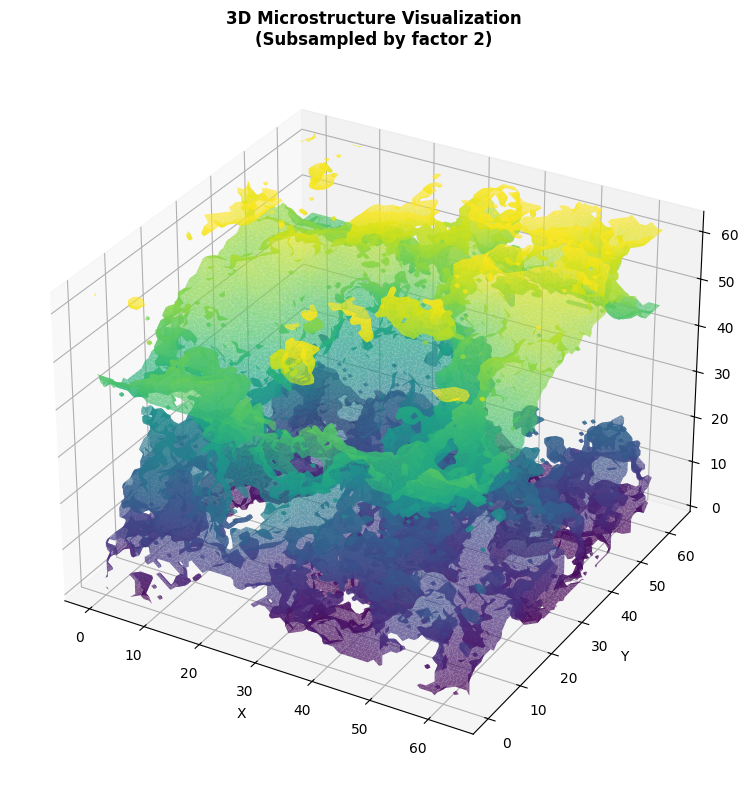


✓ Visualization complete


In [13]:
# Get the image from sample
image = sample["image"]
sample_id = sample["sample_id"]
param_id = sample["param_id"]

print(f"🔬 Visualizing Microstructure - Sample {sample_id}, Param {param_id}")
print(f"   Shape: {image.shape}")
print(f"   Value range: [{image.min():.3f}, {image.max():.3f}]")
print(f"   Porosity (fraction of 0s): {(image == 0).sum() / image.size * 100:.2f}%")
print(f"   Solid (fraction of 1s): {(image == 1).sum() / image.size * 100:.2f}%")

# Create figure with multiple views
fig = plt.figure(figsize=(18, 12))

# Get middle slices
mid_z = image.shape[0] // 2
mid_y = image.shape[1] // 2
mid_x = image.shape[2] // 2

# 2D Slice Views
# XY plane (top view)
ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(image[mid_z, :, :], cmap="gray", interpolation="nearest")
ax1.set_title(f"XY Plane (z={mid_z})", fontsize=14, fontweight="bold")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.axis("off")

# XZ plane (side view)
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(image[:, mid_y, :], cmap="gray", interpolation="nearest")
ax2.set_title(f"XZ Plane (y={mid_y})", fontsize=14, fontweight="bold")
ax2.set_xlabel("X")
ax2.set_ylabel("Z")
ax2.axis("off")

# YZ plane (front view)
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(image[:, :, mid_x], cmap="gray", interpolation="nearest")
ax3.set_title(f"YZ Plane (x={mid_x})", fontsize=14, fontweight="bold")
ax3.set_xlabel("Y")
ax3.set_ylabel("Z")
ax3.axis("off")

plt.suptitle(
    f"SEM Microstructure - Sample {sample_id} (Shape: {image.shape})",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Subsample for visualization (every nth voxel)
subsample_factor = max(1, image.shape[0] // 50)
subsampled = image[::subsample_factor, ::subsample_factor, ::subsample_factor]

# Create isosurface
try:
    threshold = subsampled.mean()
    verts, faces, _, _ = measure.marching_cubes(subsampled, threshold)

    ax.plot_trisurf(
        verts[:, 0],
        verts[:, 1],
        faces,
        verts[:, 2],
        cmap="viridis",
        alpha=0.7,
        linewidth=0,
        antialiased=True,
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(
        f"3D Microstructure Visualization\n(Subsampled by factor {subsample_factor})",
        fontsize=12,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate 3D visualization: {e}")
    print("Showing 3D scatter plot instead...")

    # Alternative: scatter plot
    threshold = subsampled.mean()
    z, y, x = np.where(subsampled > threshold)
    ax.scatter(x, y, z, c=subsampled[z, y, x], cmap="viridis", alpha=0.5, s=1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(
        f"3D Microstructure (Scatter Plot)\n(Subsampled by factor {subsample_factor})",
        fontsize=12,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()

print("\n✓ Visualization complete")

In [14]:
# Function to denormalize features
def denormalize_features(normalized, stats):
    """Denormalize features back to original scale"""
    mean = np.array(stats["mean"])
    std = np.array(stats["std"])
    std = np.where(std < 1e-8, 1.0, std)  # Avoid division by zero
    return (normalized * std) + mean


# Denormalize all features
input_params_denorm = denormalize_features(
    sample["input_params"], norm_stats["input_params"]
)

micro_outputs_denorm = denormalize_features(
    sample["microstructure_outputs"], norm_stats["microstructure_outputs"]
)

perf_outputs_denorm = denormalize_features(
    sample["performance_outputs"], norm_stats["performance_outputs"]
)

# Create display dataframes
print("=" * 80)
print(f"📊 COMPLETE DATA FOR SAMPLE {sample['sample_id']} | PARAM {sample['param_id']}")
print("=" * 80)

# Input Parameters
print("\n" + "=" * 80)
print("🔧 INPUT PARAMETERS (Battery Design)")
print("=" * 80)

input_df = pd.DataFrame(
    {
        "Feature": input_features,
        "Normalized": sample["input_params"],
        "Original Value": input_params_denorm,
    }
)

# Format scientific notation
for col in ["Normalized", "Original Value"]:
    input_df[col] = input_df[col].apply(lambda x: f"{x:.6e}")

print(input_df.to_string(index=False))

# Microstructure Outputs
print("\n" + "=" * 80)
print("🔬 MICROSTRUCTURE OUTPUTS")
print("=" * 80)

micro_df = pd.DataFrame(
    {
        "Feature": micro_features,
        "Normalized": sample["microstructure_outputs"],
        "Original Value": micro_outputs_denorm,
    }
)

for col in ["Normalized", "Original Value"]:
    micro_df[col] = micro_df[col].apply(lambda x: f"{x:.6f}")

print(micro_df.to_string(index=False))

# Performance Outputs
print("\n" + "=" * 80)
print("⚡ PERFORMANCE OUTPUTS (Battery Cycling)")
print("=" * 80)

perf_df = pd.DataFrame(
    {
        "Feature": perf_features,
        "Normalized": sample["performance_outputs"],
        "Original Value": perf_outputs_denorm,
    }
)

for col in ["Normalized", "Original Value"]:
    perf_df[col] = perf_df[col].apply(lambda x: f"{x:.6f}")

print(perf_df.to_string(index=False))

# Summary statistics
print("\n" + "=" * 80)
print("📈 SUMMARY STATISTICS")
print("=" * 80)

print(f"\nMicrostructure:")
print(f"  • Effective Diffusivity (D_eff): {micro_outputs_denorm[0]:.6f}")
print(
    f"  • Porosity: {micro_outputs_denorm[1]:.4f} ({micro_outputs_denorm[1]*100:.2f}%)"
)
print(f"  • Tortuosity Factor: {micro_outputs_denorm[2]:.4f}")
print(f"  • Bruggeman Coefficient: {micro_outputs_denorm[3]:.4f}")

print(f"\nBattery Performance:")
print(f"  • Nominal Capacity: {perf_outputs_denorm[0]:.4f} Ah")
print(f"  • End-of-Life Cycle: {int(perf_outputs_denorm[1])}")
print(f"  • Initial Capacity: {perf_outputs_denorm[2]:.4f} Ah")
print(f"  • Final Capacity: {perf_outputs_denorm[3]:.4f} Ah")
print(f"  • Capacity Retention: {perf_outputs_denorm[4]:.2f}%")
print(f"  • Total Cycles: {int(perf_outputs_denorm[5])}")

print("\n" + "=" * 80)
print("✅ Validation Complete!")
print("=" * 80)

📊 COMPLETE DATA FOR SAMPLE 0 | PARAM 0

🔧 INPUT PARAMETERS (Battery Design)
                                             Feature    Normalized Original Value
             input_SEI kinetic rate constant [m.s-1]  4.232958e-13   5.620000e-13
              input_Electrolyte diffusivity [m2.s-1]  5.423142e-11   3.540000e-10
input_Initial concentration in electrolyte [mol.m-3]  0.000000e+00   1.000000e+03
                            input_Separator porosity -3.991973e-01   5.758585e-01
 input_Separator Bruggeman coefficient (electrolyte) -1.697909e+00   2.404702e+00
               input_Separator Bruggeman coefficient -1.697909e+00   2.404702e+00
                  input_Positive particle radius [m]  4.257963e-01   5.490000e-06
                  input_Negative particle radius [m] -5.472810e-01   5.480000e-06
              input_Positive electrode thickness [m] -5.203945e-01   7.309999e-05
              input_Negative electrode thickness [m] -1.640523e+00   7.740000e-05

🔬 MICROSTRUCTURE OUTP